# Neural network for MNIST fashion dataset
Uses only basic libraries
- Numpy for linear algebra
- Pandas for storing results
- Matplotlib to plot images

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import mnist
import importlib
import layers as ly
import wandb

### Data formating
Need each datapoint ie. each image as a vector. Hence all data points are column vectors of 784 dimension

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.reshape(x_train, (-1, 784)).T / 255 # features x samples
x_test = np.reshape(x_test, (-1, 784)).T / 255 # features x samples

y_train = ly.one_hot_encode(y_train) # one-hot encode labels x samples
y_test = ly.one_hot_encode(y_test) # one-hot encode labels x samples

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print(x_train.dtype)


(784, 60000) (10, 60000) (784, 10000) (10, 10000)
float64


(28, 28, 60000)


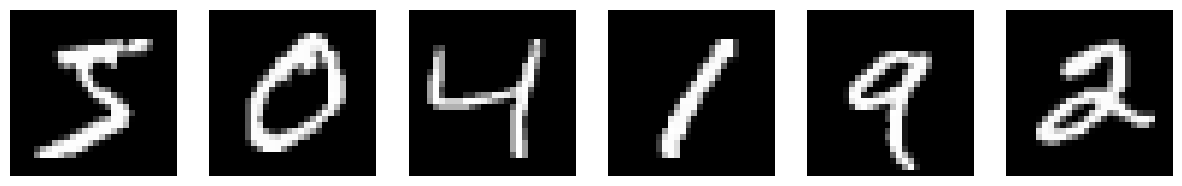

In [3]:
fig, ax = plt.subplots(1, 6, figsize=(15, 6))
plt.set_cmap('gray')
print(np.reshape(x_train, (28, 28, -1)).shape)
for i in range(6):
    ax[i].imshow(np.reshape(x_train, (28, 28, -1))[:, :, i])
    ax[i].axis('off')

In [7]:
importlib.reload(ly)

network = [ly.LayerDense(784, 32),
           ly.ActivationReLU(),
           ly.LayerDense(32, 32),
           ly.ActivationReLU(),
           ly.LayerDense(32, 10),
           ly.ActivationSoftmaxLossCrossEntropy()
]

epochs = 30
learning_rate = 0.01
batch_size = 64
total_samples = x_train.shape[1]

optimizer = ly.NestrovGradientDescent(learning_rate, momentum=0.9)

for epoch in range(epochs):
    indices = np.random.permutation(total_samples)
    x_shuffled = x_train[:, indices]
    y_shuffled = y_train[:, indices]

    epoch_loss = 0
    correct = 0

    for start in range(0, total_samples, batch_size):
        end = start + batch_size
        x_batch = x_shuffled[:, start:end]
        y_batch = y_shuffled[:, start:end]

        # Forward pass
        inputs = x_batch
        for layer in network:
            inputs = layer.forward(inputs)
        predictions = inputs

        # Loss
        loss = network[-1].loss(y_batch)
        epoch_loss += loss * x_batch.shape[1]  # Weighted sum

        # Accuracy
        y_pred = np.argmax(predictions, axis=0)
        y_label = np.argmax(y_batch, axis=0)
        correct += np.sum(y_pred == y_label)

        # Backward pass
        d_loss = network[-1].backward(y_batch)
        for layer in reversed(network[:-1]):
            d_loss = layer.backward(d_loss)

        # Update weights
        for layer in network:
            if isinstance(layer, ly.LayerDense):
                dw, db = layer.gradient()
                optimizer.update(layer)

    avg_loss = epoch_loss / total_samples
    accuracy = correct / total_samples
    print(f'Epoch {epoch}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')


Epoch 0, Loss: 0.5654, Accuracy: 0.8290
Epoch 1, Loss: 0.2322, Accuracy: 0.9310
Epoch 2, Loss: 0.1775, Accuracy: 0.9478
Epoch 3, Loss: 0.1499, Accuracy: 0.9560
Epoch 4, Loss: 0.1297, Accuracy: 0.9616
Epoch 5, Loss: 0.1167, Accuracy: 0.9655
Epoch 6, Loss: 0.1056, Accuracy: 0.9685
Epoch 7, Loss: 0.0970, Accuracy: 0.9707
Epoch 8, Loss: 0.0897, Accuracy: 0.9726
Epoch 9, Loss: 0.0830, Accuracy: 0.9749
Epoch 10, Loss: 0.0790, Accuracy: 0.9758
Epoch 11, Loss: 0.0728, Accuracy: 0.9772
Epoch 12, Loss: 0.0688, Accuracy: 0.9789
Epoch 13, Loss: 0.0645, Accuracy: 0.9796
Epoch 14, Loss: 0.0621, Accuracy: 0.9803
Epoch 15, Loss: 0.0582, Accuracy: 0.9819
Epoch 16, Loss: 0.0553, Accuracy: 0.9829
Epoch 17, Loss: 0.0520, Accuracy: 0.9839
Epoch 18, Loss: 0.0493, Accuracy: 0.9848
Epoch 19, Loss: 0.0473, Accuracy: 0.9855
Epoch 20, Loss: 0.0450, Accuracy: 0.9860
Epoch 21, Loss: 0.0426, Accuracy: 0.9866
Epoch 22, Loss: 0.0416, Accuracy: 0.9867
Epoch 23, Loss: 0.0383, Accuracy: 0.9883
Epoch 24, Loss: 0.0379, Ac

In [17]:
importlib.reload(ly) 

network = [
    ly.LayerDense(784, 128),
    ly.ActivationReLU(),
    ly.Dropout(rate=0.2),          # Dropout after first hidden layer
    ly.LayerDense(128, 64),
    ly.ActivationReLU(),
    ly.Dropout(rate=0.4),          # Dropout after second hidden layer
    ly.LayerDense(64, 32),
    ly.ActivationReLU(),
    ly.Dropout(rate=0.2),          # Dropout after third hidden layer
    ly.LayerDense(32, 10),
    ly.ActivationSoftmaxLossCrossEntropy()
]

epochs = 100
learning_rate = 0.01
batch_size = 128
total_samples = x_train.shape[1]

optimizer = ly.AdamOptimizer(learning_rate=0.001)

for epoch in range(epochs):
    indices = np.random.permutation(total_samples)
    x_shuffled = x_train[:, indices]
    y_shuffled = y_train[:, indices]

    epoch_loss = 0
    correct = 0

    for start in range(0, total_samples, batch_size):
        end = start + batch_size
        x_batch = x_shuffled[:, start:end]
        y_batch = y_shuffled[:, start:end]

        # Forward pass
        inputs = x_batch
        for layer in network:
            # Dropout is only active during training
            if isinstance(layer, ly.Dropout):
                inputs = layer.forward(inputs, training=True)
            else:
                inputs = layer.forward(inputs)
        predictions = inputs

        # Loss
        loss = network[-1].loss(y_batch)
        epoch_loss += loss * x_batch.shape[1]  # Weighted sum

        # Accuracy
        y_pred = np.argmax(predictions, axis=0)
        y_label = np.argmax(y_batch, axis=0)
        correct += np.sum(y_pred == y_label)

        # Backward pass
        d_loss = network[-1].backward(y_batch)
        for layer in reversed(network[:-1]):
            d_loss = layer.backward(d_loss)

        # Update weights
        for layer in network:
            if isinstance(layer, ly.LayerDense):
                dw, db = layer.gradient()
                optimizer.update(layer)

    avg_loss = epoch_loss / total_samples
    accuracy = correct / total_samples
    if epoch%5 == 0:
        print(f'Epoch {epoch}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')


Epoch 0, Loss: 0.6196, Accuracy: 0.8058
Epoch 5, Loss: 0.1315, Accuracy: 0.9640
Epoch 10, Loss: 0.0912, Accuracy: 0.9742
Epoch 15, Loss: 0.0745, Accuracy: 0.9789
Epoch 20, Loss: 0.0642, Accuracy: 0.9819
Epoch 25, Loss: 0.0558, Accuracy: 0.9835
Epoch 30, Loss: 0.0506, Accuracy: 0.9851
Epoch 35, Loss: 0.0467, Accuracy: 0.9865
Epoch 40, Loss: 0.0452, Accuracy: 0.9866
Epoch 45, Loss: 0.0390, Accuracy: 0.9884
Epoch 50, Loss: 0.0366, Accuracy: 0.9892
Epoch 55, Loss: 0.0331, Accuracy: 0.9899
Epoch 60, Loss: 0.0334, Accuracy: 0.9903
Epoch 65, Loss: 0.0294, Accuracy: 0.9913
Epoch 70, Loss: 0.0308, Accuracy: 0.9909
Epoch 75, Loss: 0.0283, Accuracy: 0.9916
Epoch 80, Loss: 0.0300, Accuracy: 0.9904
Epoch 85, Loss: 0.0294, Accuracy: 0.9913
Epoch 90, Loss: 0.0262, Accuracy: 0.9924
Epoch 95, Loss: 0.0271, Accuracy: 0.9922


In [32]:
# test
inputs = x_test
for layer in network:
    inputs = layer.forward(inputs)
predictions = inputs
y_pred = np.argmax(predictions, axis=0)
y_label = np.argmax(y_test, axis=0)
correct = np.sum(y_pred == y_label)
accuracy = correct / y_test.shape[1]
print(f'Test Accuracy: {100*accuracy:.2f}%')


Test Accuracy: 97.16%
